# [Question 1]
TODO download data and unzip archive file commands

In [3]:
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-04.csv nyc_tlc/trip_data/yellow_tripdata_2018-04.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-05.csv nyc_tlc/trip_data/yellow_tripdata_2018-05.csv
!aws s3 cp s3://nyc-tlc/trip\ data/yellow_tripdata_2018-06.csv nyc_tlc/trip_data/yellow_tripdata_2018-06.csv
!aws s3 cp s3://nyc-tlc/misc/taxi\ _zone_lookup.csv nyc_tlc/misc/taxi_zone_lookup.csv
!aws s3 cp s3://nyc-tlc/misc/taxi_zones.zip nyc_tlc/misc/taxi_zones.zip
!cd nyc_tlc/misc/ && rm -rf taxi_zones && unzip taxi_zones.zip -d taxi_zones

download failed: s3://nyc-tlc/trip data/yellow_tripdata_2018-04.csv to nyc_tlc/trip_data/yellow_tripdata_2018-04.csv [Errno 28] No space left on device
download failed: s3://nyc-tlc/trip data/yellow_tripdata_2018-05.csv to nyc_tlc/trip_data/yellow_tripdata_2018-05.csv [Errno 28] No space left on device
download failed: s3://nyc-tlc/trip data/yellow_tripdata_2018-06.csv to nyc_tlc/trip_data/yellow_tripdata_2018-06.csv [Errno 28] No space left on device
download: s3://nyc-tlc/misc/taxi _zone_lookup.csv to nyc_tlc/misc/taxi_zone_lookup.csv
download: s3://nyc-tlc/misc/taxi_zones.zip to nyc_tlc/misc/taxi_zones.zip
Archive:  taxi_zones.zip
  inflating: taxi_zones/taxi_zones.prj  
  inflating: taxi_zones/taxi_zones.dbf  
  inflating: taxi_zones/taxi_zones.shp  
  inflating: taxi_zones/taxi_zones.shp.xml  
  inflating: taxi_zones/taxi_zones.shx  
  inflating: taxi_zones/taxi_zones.sbn  
  inflating: taxi_zones/taxi_zones.sbx  


Validate [Question 1], you should get:

```
nyc_tlc
├── misc
│   ├── taxi_zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip_data
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 12 files
```

In [1]:
!tree nyc_tlc

nyc_tlc
├── misc
│   ├── taxi_zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip_data
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 12 files


## Basic Preparation

We import all useful packages, do some basic/global settings.

In [1]:
# imports

import time
import pickle
import datetime
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

import logging

import contest_helper

In [2]:
# global setting
logger = logging.getLogger()
logger.setLevel(logging.INFO)

plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

## Taxi Zones Shape Preparation

Since newest NYC Taxi dataset only provides `PULocationID` and `DOLocationID`, instead of `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`, we can only predict requests in each `PULocationID` (zone). We load [taxi_zone_lookup.csv] and [taxi_zones.shp], and use `geopandas` to visualize the zones in Manhattan (69 in total).

contest_helper.NycTaxiAnalyzer is a wrapper class to load and present taxi data and zones shape.
1. contest_helper.NycTaxiAnalyzer.taxi_zone_lookup: pandas.DataFrame
1. contest_helper.NycTaxiAnalyzer.taxi_zones_shape: geopandas.GeoDataFrame

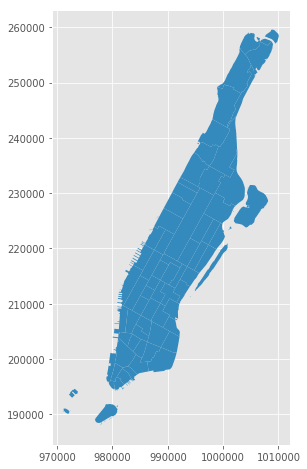

In [3]:
nyc_taxi_analyzer = contest_helper.NycTaxiAnalyzer()

nyc_taxi_analyzer.load_shape('nyc_tlc/misc/taxi_zone_lookup.csv',
                            'nyc_tlc/misc/taxi_zones/taxi_zones.shp',
                            borough='Manhattan')

nyc_taxi_analyzer.taxi_zones_shape.plot()


# [Question 2]
TODO:
1. load Manhattan data: from 2018-04 to 2018-06
1. define a function 'filter_abnormal_data' to filter abnormal data in 'contest_helper.NycTaxiAnalyzer.data'
1. call filter_abnormal_data to filter 'contest_helper.NycTaxiAnalyzer.data'



## Load data

We split the dataset into two parts: train and validate by setting `train_valid_split_datetime` to 2018-06-01 00:00:00.
We set `first_datetime` to 2018-04-01 00:00:00, and `last_datetime` to 2018-07-01 00:00:00.
We load all data from [nyc_tlc/trip_data/] between `first_datetime` and `last_datetime`.
We use `matplotlib` and `geopandas` to visualize some columns and help us to understand the trip data.

In [4]:
# first_datetime '2018-04-01 00:00:00'
fd = datetime.datetime.strptime('2018-04-01 00:00:00', '%Y-%m-%d %H:%M:%S')
# last_datetime '2018-07-01 00:00:00'
ld = datetime.datetime.strptime('2018-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')
# train_valid_split_datetime '2018-06-01 00:00:00'
tvsd = datetime.datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')

nyc_taxi_analyzer.load_data('nyc_tlc/trip_data/', first_datetime=fd, last_datetime=ld)


INFO:root:read_csv 2018-04: 16.62335181236267
INFO:root:filter PULocationID: 1.6795451641082764 (8428796, 17)
INFO:root:tpep_pickup_datetime: 1.906975269317627 (8428796, 17)
INFO:root:tpep_dropoff_datetime: 1.8043277263641357 (8428796, 17)
INFO:root:filter tpep_pickup_datetime first_datetime: 1.0984618663787842 (8428431, 17)
INFO:root:filter tpep_pickup_datetime last_datetime: 0.919203519821167 (8428418, 17)
INFO:root:tpep_dropoff_datetime - tpep_pickup_datetime: 1.0347545146942139 (8428418, 1)
INFO:root:trip_duration: 0.7518033981323242 (8428418, 18)
INFO:root:trip_speed: 2.5483453273773193 (8428418, 19)
INFO:root:filter date: 33.20625877380371 (8428418, 20)
INFO:root:store_and_fwd_flag: 2.3152613639831543 (8428418, 20)
INFO:root:tpep_pickup_5min_id: 0.7027599811553955 (8428418, 21)
INFO:root:tpep_pickup_15min_id: 0.695223331451416 (8428418, 22)
INFO:root:tpep_pickup_30min_id: 0.6911613941192627 (8428418, 23)
INFO:root:read_csv 2018-05: 16.462981462478638
INFO:root:filter PULocationID

## Filter abnormal data

Define a function, and filter abnormal data.
Acceptable data should be validated like below,
1. trip_distance > 0
1. trip_duration > 0
1. trip_speed <= 200
1. total_amount > 0

In [5]:
nyc_taxi_analyzer.data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,date,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,2018-04-01 00:47:37,2018-04-01 01:08:42,1,6.700,1,1,152,90,2,22.500,0.500,0.500,0.000,0.000,0.300,23.800,1265.000,19.067,2018-04-01,9.000,3.000,1.000
1,1,2018-04-01 00:02:13,2018-04-01 00:17:52,2,4.100,1,1,239,158,1,15.500,0.500,0.500,3.350,0.000,0.300,20.150,939.000,15.719,2018-04-01,0.000,0.000,0.000
2,1,2018-04-01 00:46:49,2018-04-01 00:52:05,1,0.700,1,1,90,249,1,5.500,0.500,0.500,1.350,0.000,0.300,8.150,316.000,7.975,2018-04-01,9.000,3.000,1.000
3,1,2018-04-01 00:19:43,2018-04-01 00:24:46,1,0.900,1,1,238,142,1,5.500,0.500,0.500,1.020,0.000,0.300,7.820,303.000,10.693,2018-04-01,3.000,1.000,0.000
4,1,2018-04-01 00:29:23,2018-04-01 00:38:17,1,1.600,1,1,239,262,2,8.500,0.500,0.500,0.000,0.000,0.300,9.800,534.000,10.787,2018-04-01,5.000,1.000,0.000


In [6]:
# your solution goes here:

def filter_abnormal_data(data):
    return data


nyc_taxi_analyzer.filter_abnormal_data()
sample = filter_abnormal_data(nyc_taxi_analyzer.data)

sample.shape

INFO:root:filter trip_distance>0: 8.677459955215454 (24562056, 23)
INFO:root:filter trip_duration>0: 3.5310792922973633 (24561526, 23)
INFO:root:filter trip_speed<=200: 7.1586480140686035 (24551537, 23)
INFO:root:filter total_amount>0: 3.5503058433532715 (24540246, 23)
INFO:root:sample.shape: (24540246, 23)


(24540246, 23)

Validate [Question 2], you should get `sample.shape: (24540246, 23)`

# [Question 3]

In [7]:
# Caculate and present hit-map of taxi needs per PULocationID [Question 3.1]
nyc_taxi_analyzer.data.head()



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,date,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,2018-04-01 00:47:37,2018-04-01 01:08:42,1,6.700,1,1,152,90,2,22.500,0.500,0.500,0.000,0.000,0.300,23.800,1265.000,19.067,2018-04-01,9.000,3.000,1.000
1,1,2018-04-01 00:02:13,2018-04-01 00:17:52,2,4.100,1,1,239,158,1,15.500,0.500,0.500,3.350,0.000,0.300,20.150,939.000,15.719,2018-04-01,0.000,0.000,0.000
2,1,2018-04-01 00:46:49,2018-04-01 00:52:05,1,0.700,1,1,90,249,1,5.500,0.500,0.500,1.350,0.000,0.300,8.150,316.000,7.975,2018-04-01,9.000,3.000,1.000
3,1,2018-04-01 00:19:43,2018-04-01 00:24:46,1,0.900,1,1,238,142,1,5.500,0.500,0.500,1.020,0.000,0.300,7.820,303.000,10.693,2018-04-01,3.000,1.000,0.000
4,1,2018-04-01 00:29:23,2018-04-01 00:38:17,1,1.600,1,1,239,262,2,8.500,0.500,0.500,0.000,0.000,0.300,9.800,534.000,10.787,2018-04-01,5.000,1.000,0.000


taxi_zones_shape_requests: (69, 8)


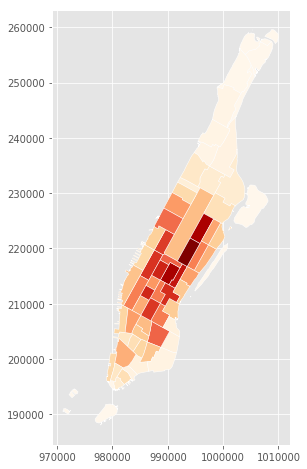

In [8]:
PULocationID_group = nyc_taxi_analyzer.data.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group

taxi_zones_shape_requests = nyc_taxi_analyzer.taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
print('taxi_zones_shape_requests:', taxi_zones_shape_requests.shape)

taxi_zones_shape_requests.head()
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')



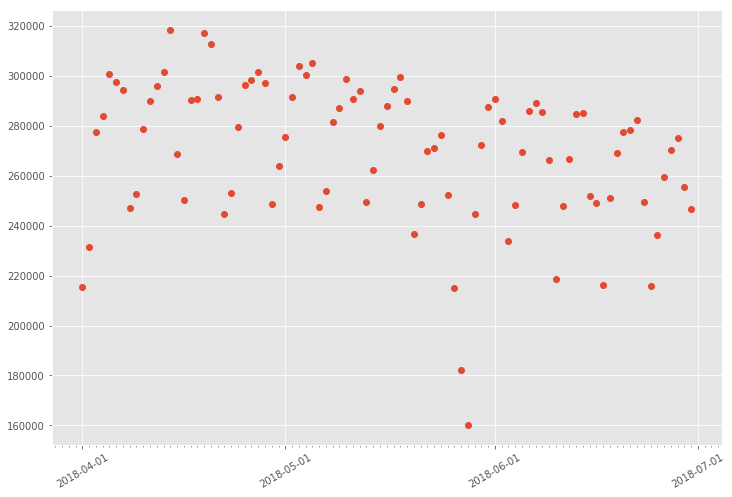

In [11]:
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.dates as mdates
import datetime

day_group = sample.groupby(['date'])\
        .agg({'VendorID':'count', 'total_amount':'sum'})\
        .reset_index()\
        .reindex(columns=['date','VendorID','total_amount'])

loc = matplotlib.dates.MonthLocator()
day_fmt = DateFormatter('%m-%d')
days = mdates.DayLocator()   # every day
month_fmt = mdates.DateFormatter('%Y-%m-%d')
datemin = pd.to_datetime(np.datetime64(sample['date'].min(), 'm'))
datemax = pd.to_datetime(np.datetime64(sample['date'].max(), 'm') + np.timedelta64(1, 'm'))
delta = datetime.timedelta(days=1)

dates = drange(datemin, datemax, delta)
s = day_group['VendorID']

fig, ax = plt.subplots()
plt.plot_date(dates, s)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()



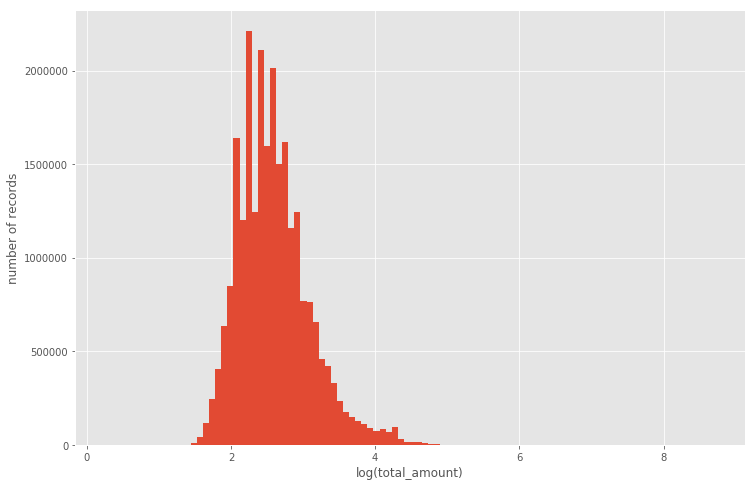

In [20]:
# Show statistics of the prepared sample data [Question 3.2]
nyc_taxi_analyzer.data.describe()

sample = nyc_taxi_analyzer.data
sample['log_total_amount'] = np.log(sample['total_amount'].values + 1)
plt.hist(sample['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()

In [30]:
sample = nyc_taxi_analyzer.data
day_group = sample.groupby(['date'])\
        .agg({'VendorID':'count', 'total_amount':'sum'})\
        .reset_index()\
        .reindex(columns=['date','VendorID','total_amount'])
day_group

,date,VendorID,total_amount
0,2018-04-01,215469,2865605.260
1,2018-04-02,231280,3059138.640
2,2018-04-03,277526,3878271.690
3,2018-04-04,283766,3988334.160
4,2018-04-05,300644,4294819.640
5,2018-04-06,297542,4205959.770
6,2018-04-07,294454,3968653.230
7,2018-04-08,246894,3390323.610
8,2018-04-09,252774,3435009.670
9,2018-04-10,278673,3877875.700


## [Challenge Question]

TODO: Add new prediction algorithm or change parameters of above 4 prediction algorithms

## Feature Prepare

We set the `5min_id`, `15min_id` and `30min_id` to represent 5min, 15min and 30min slot. For example, time between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 has a `5min_id` as 0, and time between 2018-01-01 00:05:00 and 2018-01-01 00:10:00 has a `5min_id` as 1, and the similar with `15min_id` and `30min_id`. For each `Xmin_id` (X represents 5, 15 or 30), we predict the requests in all 69 zones. We have some `static features` such as `month`, `day`, `hour`, `weekday`, `is_weekend`, `is_morning_peak`, `is_evening_pick` for all `Xmin_id` and zones. Also we can extend more static features such as weather and zone features. Other `dynamic features` includes requests in `5min ago`, `10min ago`, `15min ago`, `7days ago`, etc. Also we can extend more dynamic features such as total passengers in 5min ago. At last, we generate 34 features for each `Xmin_id` and zone.

In [41]:
first_5min_id = nyc_taxi_analyzer.get_5min_id(fd)
first_15min_id = nyc_taxi_analyzer.get_15min_id(fd)
first_30min_id = nyc_taxi_analyzer.get_30min_id(fd)


last_5min_id = nyc_taxi_analyzer.get_5min_id(ld)
last_15min_id = nyc_taxi_analyzer.get_15min_id(ld)
last_30min_id = nyc_taxi_analyzer.get_30min_id(ld)


train_valid_split_5min_id = nyc_taxi_analyzer.get_5min_id(tvsd)
train_valid_split_15min_id = nyc_taxi_analyzer.get_15min_id(tvsd)
train_valid_split_30min_id = nyc_taxi_analyzer.get_30min_id(tvsd)

all_5min_index, all_5min_static = nyc_taxi_analyzer.get_all_index_and_static(last_5min_id, 'tpep_pickup_5min_id')
all_15min_index, all_15min_static = nyc_taxi_analyzer.get_all_index_and_static(last_15min_id, 'tpep_pickup_15min_id')
all_30min_index, all_30min_static = nyc_taxi_analyzer.get_all_index_and_static(last_30min_id, 'tpep_pickup_30min_id')

all_id: (0,) []
all_LocationID: (0,) []
all_index: (0, 0)
tpep_pickup_datetime: 0.003784656524658203
tpep_pickup_month: 0.004495143890380859
tpep_pickup_day: 0.005139827728271484
tpep_pickup_hour: 0.005883216857910156
tpep_pickup_weekday: 0.006736040115356445
is_weekend: 0.00743865966796875
is_morning_peak: 0.008019685745239258
is_evening_peak: 0.008694887161254883
all_static: (0, 7)
all_id: (0,) []
all_LocationID: (0,) []
all_index: (0, 0)
tpep_pickup_datetime: 0.002886056900024414
tpep_pickup_month: 0.003688812255859375
tpep_pickup_day: 0.00434422492980957
tpep_pickup_hour: 0.005073070526123047
tpep_pickup_weekday: 0.005797386169433594
is_weekend: 0.00667119026184082
is_morning_peak: 0.00726008415222168
is_evening_peak: 0.008149862289428711
all_static: (0, 7)
all_id: (0,) []
all_LocationID: (0,) []
all_index: (0, 0)
tpep_pickup_datetime: 0.0031325817108154297
tpep_pickup_month: 0.0037479400634765625
tpep_pickup_day: 0.004363298416137695
tpep_pickup_hour: 0.0050771236419677734
tpep_pi

In [42]:
all_5min_index.head()

,
tpep_pickup_5min_id,LocationID


In [43]:
all_5min_index.tail()

,
tpep_pickup_5min_id,LocationID


In [44]:
all_5min_static.head()

,,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak
tpep_pickup_5min_id,LocationID,,,,,,,


In [45]:
all_5min_static.tail()

,,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak
tpep_pickup_5min_id,LocationID,,,,,,,


In [46]:
def get_sample_group(id_name, sample_manhattan):
    sample_group = sample_manhattan.groupby([id_name, 'PULocationID'])
    sample_count = sample_group.count()
    sample_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_count:', sample_count.shape)
    sample_mean = sample_group.mean()
    sample_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_mean:', sample_mean.shape)
    sample_sum = sample_group.sum()
    sample_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_sum:', sample_sum.shape)
    sample_dropoff_group = sample_manhattan.groupby([id_name, 'DOLocationID'])
    sample_dropoff_count = sample_dropoff_group.count()
    sample_dropoff_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_count:', sample_dropoff_count.shape)
    sample_dropoff_mean = sample_dropoff_group.mean()
    sample_dropoff_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_mean:', sample_dropoff_mean.shape)
    sample_dropoff_sum = sample_dropoff_group.sum()
    sample_dropoff_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_sum:', sample_dropoff_sum.shape)
    return sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum

In [88]:
sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum = get_sample_group('tpep_pickup_5min_id', nyc_taxi_analyzer.data)
sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum = get_sample_group('tpep_pickup_15min_id', nyc_taxi_analyzer.data)
sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum = get_sample_group('tpep_pickup_30min_id', nyc_taxi_analyzer.data)

sample_count: (219515, 22)
sample_mean: (219515, 22)
sample_sum: (219515, 22)
sample_dropoff_count: (298108, 22)
sample_dropoff_mean: (298108, 22)
sample_dropoff_sum: (298108, 22)
sample_count: (138288, 22)
sample_mean: (138288, 22)
sample_sum: (138288, 22)
sample_dropoff_count: (234611, 22)
sample_dropoff_mean: (234611, 22)
sample_dropoff_sum: (234611, 22)
sample_count: (96262, 22)
sample_mean: (96262, 22)
sample_sum: (96262, 22)
sample_dropoff_count: (185754, 22)
sample_dropoff_mean: (185754, 22)
sample_dropoff_sum: (185754, 22)


In [89]:
sample_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               25                 4                4              4   
                    61                 1                1              1   
                    65                 5                5              5   
                    80                 5                5              5   
                    97                 2                2              2   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               25                   4                   4             4   
                    61                   1                   1             1   
                    65                   5                   5             5   
                    80                   5                   5             5   
                    97                   2                   2             2   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               25                     4            4      4        4   
                    61                     1            1      1        1   
                    65                     5            5      5        5   
                    80                     5            5      5        5   
                    97                     2            2      2        2   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               25                   4             4   
                    61                   1             1   
                    65                   5             5   
                    80                   5             5   
                    97                   2             2   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               25                              4             4   
                    61                              1             1   
                    65                              5             5   
                    80                              5             5   
                    97                              2             2   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               25                      4           4   
                    61                      1           1   
                    65                      5           5   
                    80                      5           5   
                    97                      2           2   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               25                             4                     4   
                    61                             1                     1   
                    65                             5                     5   
                    80                             5                     5   
                    97                             2                     2   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               25                         4                  4   
                    61                         1                  1   
                    65                         5                  5   
                    80                         5                  5   
                    97                         2                  2   

      

In [90]:
sample_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               25             1.500            1.750          2.525   
                    61             1.000            1.000          2.300   
                    65             1.600            1.000          3.560   
                    80             1.600            2.200          5.976   
                    97             1.000            2.000          4.050   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               25               1.000               1.000        77.750   
                    61               1.000               1.000        89.000   
                    65               1.000               1.000       109.800   
                    80               1.000               1.000       118.600   
                    97               1.000               1.000       139.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               25                 1.250       11.000  0.500    0.500   
                    61                 1.000       10.500  0.500    0.500   
                    65                 1.400       13.300  0.500    0.500   
                    80                 1.400       19.900  0.500    0.500   
                    97                 1.000       14.000  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               25               1.770         0.000   
                    61               2.950         0.000   
                    65               1.670         0.000   
                    80               3.214         0.000   
                    97               3.050         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               25                          0.300        14.070   
                    61                          0.300        14.750   
                    65                          0.300        16.270   
                    80                          0.300        24.414   
                    97                          0.300        18.350   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               25                738.500      12.890   
                    61                755.000      10.967   
                    65                791.000      15.103   
                    80               1057.800      24.320   
                    97                710.500      16.805   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               25                         0.000                 0.000   
                    61                         0.000                 0.000   
                    65                         0.000                 0.000   
                    80                         0.000                 0.000   
                    97                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               25                     2.630              1.160   
                    61                     2.757              1.194   
                    65                     2.740              1.352   
                    80                     3.104              1.816   
                    97                     2.800              1.373   

      

In [91]:
sample_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               25                 6                7         10.100   
                    61                 1                1          2.300   
                    65                 8                5         17.800   
                    80                 8               11         29.880   
                    97                 2                4          8.100   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               25                   4                   4           311   
                    61                   1                   1            89   
                    65                   5                   5           549   
                    80                   5                   5           593   
                    97                   2                   2           278   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               25                     5       44.000  2.000    2.000   
                    61                     1       10.500  0.500    0.500   
                    65                     7       66.500  2.500    2.500   
                    80                     7       99.500  2.500    2.500   
                    97                     2       28.000  1.000    1.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               25               7.080         0.000   
                    61               2.950         0.000   
                    65               8.350         0.000   
                    80              16.070         0.000   
                    97               6.100         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               25                          1.200        56.280   
                    61                          0.300        14.750   
                    65                          1.500        81.350   
                    80                          1.500       122.070   
                    97                          0.600        36.700   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               25               2954.000      51.560   
                    61                755.000      10.967   
                    65               3955.000      75.517   
                    80               5289.000     121.602   
                    97               1421.000      33.610   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               25                         0.000                 0.000   
                    61                         0.000                 0.000   
                    65                         0.000                 0.000   
                    80                         0.000                 0.000   
                    97                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               25                    10.519              4.641   
                    61                     2.757              1.194   
                    65                    13.698              6.762   
                    80                    15.522              9.080   
                    97                     5.600              2.746   

      

In [92]:
sample_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               7                  1                1              1   
                    33                 1                1              1   
                    40                 2                2              2   
                    49                 2                2              2   
                    52                 2                2              2   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               7                    1                   1             1   
                    33                   1                   1             1   
                    40                   2                   2             2   
                    49                   2                   2             2   
                    52                   2                   2             2   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               7                      1            1      1        1   
                    33                     1            1      1        1   
                    40                     2            2      2        2   
                    49                     2            2      2        2   
                    52                     2            2      2        2   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               7                    1             1   
                    33                   1             1   
                    40                   2             2   
                    49                   2             2   
                    52                   2             2   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               7                               1             1   
                    33                              1             1   
                    40                              2             2   
                    49                              2             2   
                    52                              2             2   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               7                       1           1   
                    33                      1           1   
                    40                      2           2   
                    49                      2           2   
                    52                      2           2   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               7                              1                     1   
                    33                             1                     1   
                    40                             2                     2   
                    49                             2                     2   
                    52                             2                     2   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               7                          1                  1   
                    33                         1                  1   
                    40                         2                  2   
                    49                         2                  2   
                    52                         2                  2   

      

In [93]:
sample_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               7              2.000            1.000          7.210   
                    33             2.000            1.000          0.910   
                    40             1.500            1.000          4.040   
                    49             1.500            2.000          1.005   
                    52             1.500            4.000          3.145   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               7                1.000               1.000       255.000   
                    33               1.000               1.000        65.000   
                    40               1.000               1.000        52.500   
                    49               1.000               1.000        81.000   
                    52               1.000               1.000        52.500   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               7                  1.000       23.000  0.500    0.500   
                    33                 2.000        7.000  0.500    0.500   
                    40                 1.500       14.000  0.500    0.500   
                    49                 1.000        5.500  0.500    0.500   
                    52                 1.000       11.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               7                4.860         0.000   
                    33               0.000         0.000   
                    40               2.175         0.000   
                    49               1.525         0.000   
                    52               2.930         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               7                           0.300        29.160   
                    33                          0.300         8.300   
                    40                          0.300        17.475   
                    49                          0.300         8.325   
                    52                          0.300        15.730   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               7                1156.000      22.453   
                    33                480.000       6.825   
                    40                686.000      19.068   
                    49                295.000      12.538   
                    52                556.000      17.409   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               7                          0.000                 0.000   
                    33                         0.000                 0.000   
                    40                         0.000                 0.000   
                    49                         0.000                 0.000   
                    52                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               7                      3.407              2.105   
                    33                     2.230              0.647   
                    40                     2.792              1.481   
                    49                     2.233              0.694   
                    52                     2.707              1.229   

      

In [94]:
sample_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               7                  2                1          7.210   
                    33                 2                1          0.910   
                    40                 3                2          8.080   
                    49                 3                4          2.010   
                    52                 3                8          6.290   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               7                    1                   1           255   
                    33                   1                   1            65   
                    40                   2                   2           105   
                    49                   2                   2           162   
                    52                   2                   2           105   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               7                      1       23.000  0.500    0.500   
                    33                     2        7.000  0.500    0.500   
                    40                     3       28.000  1.000    1.000   
                    49                     2       11.000  1.000    1.000   
                    52                     2       23.000  1.000    1.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               7                4.860         0.000   
                    33               0.000         0.000   
                    40               4.350         0.000   
                    49               3.050         0.000   
                    52               5.860         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               7                           0.300        29.160   
                    33                          0.300         8.300   
                    40                          0.600        34.950   
                    49                          0.600        16.650   
                    52                          0.600        31.460   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               7                1156.000      22.453   
                    33                480.000       6.825   
                    40               1372.000      38.136   
                    49                590.000      25.075   
                    52               1112.000      34.818   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               7                          0.000                 0.000   
                    33                         0.000                 0.000   
                    40                         0.000                 0.000   
                    49                         0.000                 0.000   
                    52                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               7                      3.407              2.105   
                    33                     2.230              0.647   
                    40                     5.584              2.963   
                    49                     4.465              1.389   
                    52                     5.415              2.458   

      

In [95]:
def get_all(all_index, sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum):
    all_count = all_index.join(sample_count, how='left')
    all_count.fillna(0, inplace=True)
    print('all_count:', all_count.shape)
    all_mean = all_index.join(sample_mean, how='left')
    all_mean.fillna(0, inplace=True)
    print('all_mean:', all_mean.shape)
    all_sum = all_index.join(sample_sum, how='left')
    all_sum.fillna(0, inplace=True)
    print('all_sum:', all_sum.shape)
    all_dropoff_count = all_index.join(sample_dropoff_count, how='left')
    all_dropoff_count.fillna(0, inplace=True)
    print('all_dropoff_count:', all_dropoff_count.shape)
    all_dropoff_mean = all_index.join(sample_dropoff_mean, how='left')
    all_dropoff_mean.fillna(0, inplace=True)
    print('all_dropoff_mean:', all_dropoff_mean.shape)
    all_dropoff_sum = all_index.join(sample_dropoff_sum, how='left')
    all_dropoff_sum.fillna(0, inplace=True)
    print('all_dropoff_sum:', all_dropoff_sum.shape)
    all_xmin = all_count.copy()
    all_xmin = all_xmin.join(all_mean, lsuffix='_count', rsuffix='_mean')
    all_xmin = all_xmin.join(all_sum, rsuffix='_sum')
    all_xmin = all_xmin.join(all_dropoff_count, rsuffix='_dropoff_count')
    all_xmin = all_xmin.join(all_dropoff_mean, rsuffix='_dropoff_mean')
    all_xmin = all_xmin.join(all_dropoff_sum, rsuffix='_dropoff_sum')
    print('all_xmin:', all_xmin.shape)
    return all_xmin

In [96]:
all_5min = get_all(all_5min_index, sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum)
all_15min = get_all(all_15min_index, sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum)
all_30min = get_all(all_30min_index, sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum)

all_count: (1598688, 22)
all_mean: (1598688, 22)
all_sum: (1598688, 22)
all_dropoff_count: (1598688, 22)
all_dropoff_mean: (1598688, 22)
all_dropoff_sum: (1598688, 22)
all_xmin: (1598688, 132)
all_count: (532896, 22)
all_mean: (532896, 22)
all_sum: (532896, 22)
all_dropoff_count: (532896, 22)
all_dropoff_mean: (532896, 22)
all_dropoff_sum: (532896, 22)
all_xmin: (532896, 132)
all_count: (266448, 22)
all_mean: (266448, 22)
all_sum: (266448, 22)
all_dropoff_count: (266448, 22)
all_dropoff_mean: (266448, 22)
all_dropoff_sum: (266448, 22)
all_xmin: (266448, 132)


In [97]:
all_5min.head()

VendorID_count  passenger_count_count  \
tpep_pickup_5min_id LocationID                                          
0                   11                   0.000                  0.000   
                    14                   0.000                  0.000   
                    17                   0.000                  0.000   
                    21                   0.000                  0.000   
                    22                   0.000                  0.000   

                                trip_distance_count  RatecodeID_count  \
tpep_pickup_5min_id LocationID                                          
0                   11                        0.000             0.000   
                    14                        0.000             0.000   
                    17                        0.000             0.000   
                    21                        0.000             0.000   
                    22                        0.000             0.000   

                                store_and_fwd_flag_count  DOLocationID_count  \
tpep_pickup_5min_id LocationID                                                 
0                   11                             0.000               0.000   
                    14                             0.000               0.000   
                    17                             0.000               0.000   
                    21                             0.000               0.000   
                    22                             0.000               0.000   

                                payment_type_count  fare_amount_count  \
tpep_pickup_5min_id LocationID                                          
0                   11                       0.000              0.000   
                    14                       0.000              0.000   
                    17                       0.000              0.000   
                    21                       0.000              0.000   
                    22                       0.000              0.000   

                                extra_count  mta_tax_count  tip_amount_count  \
tpep_pickup_5min_id LocationID                                                 
0                   11                0.000          0.000             0.000   
                    14                0.000          0.000             0.000   
                    17                0.000          0.000             0.000   
                    21                0.000          0.000             0.000   
                    22                0.000          0.000             0.000   

                                tolls_amount_count  \
tpep_pickup_5min_id LocationID                       
0                   11                       0.000   
                    14                       0.000   
                    17                       0.000   
                    21                       0.000   
                    22                       0.000   

                                improvement_surcharge_count  \
tpep_pickup_5min_id LocationID                                
0                   11                                0.000   
                    14                                0.000   
                    17                                0.000   
                    21                                0.000   
                    22                                0.000   

                                total_amount_count  trip_duration_count  \
tpep_pickup_5min_id LocationID                                            
0                   11                       0.000                0.000   
                    14                       0.000                0.000   
                    17                       0.000                0.000   
                    21                       0.000                0.000   
                    22                       0.000                0.000   

                           

In [98]:
def get_all_features(all_xmin, all_static, manhattan_location_num):
    all_xmin_features = all_static.copy()
    all_xmin_features['value'] = all_xmin['VendorID_count']
    all_xmin_features['5min_ago'] = all_xmin['VendorID_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago'] = all_xmin['VendorID_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago'] = all_xmin_features['5min_ago'] + all_xmin_features['5min_10min_ago']
    all_xmin_features['10min_15min_ago'] = all_xmin['VendorID_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago'] = all_xmin_features['10min_ago'] + all_xmin_features['10min_15min_ago']
    all_xmin_features['15min_20min_ago'] = all_xmin['VendorID_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago'] = all_xmin_features['15min_ago'] + all_xmin_features['15min_20min_ago']
    all_xmin_features['20min_25min_ago'] = all_xmin['VendorID_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago'] = all_xmin_features['20min_ago'] + all_xmin_features['20min_25min_ago']
    all_xmin_features['25min_30min_ago'] = all_xmin['VendorID_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago'] = all_xmin_features['25min_ago'] + all_xmin_features['25min_30min_ago']
    all_xmin_features['5min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago_drop'] = all_xmin_features['5min_ago_drop'] + all_xmin_features['5min_10min_ago_drop']
    all_xmin_features['10min_15min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago_drop'] = all_xmin_features['10min_ago_drop'] + all_xmin_features['10min_15min_ago_drop']
    all_xmin_features['15min_20min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago_drop'] = all_xmin_features['15min_ago_drop'] + all_xmin_features['15min_20min_ago_drop']
    all_xmin_features['20min_25min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago_drop'] = all_xmin_features['20min_ago_drop'] + all_xmin_features['20min_25min_ago_drop']
    all_xmin_features['25min_30min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago_drop'] = all_xmin_features['25min_ago_drop'] + all_xmin_features['25min_30min_ago_drop']
    all_xmin_features['1day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24)
    all_xmin_features['7day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*7)
    all_xmin_features['14day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*14)
    all_xmin_features['21day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*21)
    all_xmin_features['28day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*28)
    all_xmin_features.fillna(0, inplace=True)
    print('all_xmin_features:', all_xmin_features.shape)
    return all_xmin_features

In [99]:
all_5min_features = get_all_features(all_5min, all_5min_static, nyc_taxi_analyzer.location_num)
all_15min_features = get_all_features(all_15min, all_15min_static, nyc_taxi_analyzer.location_num)
all_30min_features = get_all_features(all_30min, all_30min_static, nyc_taxi_analyzer.location_num)

all_xmin_features: (1598688, 35)
all_xmin_features: (532896, 35)
all_xmin_features: (266448, 35)


In [100]:
all_5min_features.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   11                          4                1   
                    14                          4                1   
                    17                          4                1   
                    21                          4                1   
                    22                          4                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   11                         0                    6   
                    14                         0                    6   
                    17                         0                    6   
                    21                         0                    6   
                    22                         0                    6   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   11                   1                0                0   
                    14                   1                0                0   
                    17                   1                0                0   
                    21                   1                0                0   
                    22                   1                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   11          0.000     0.000           0.000      0.000   
                    14          0.000     0.000           0.000      0.000   
                    17          0.000     0.000           0.000      0.000   
                    21          0.000     0.000           0.000      0.000   
                    22          0.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   11                    0.000      0.000            0.000   
                    14                    0.000      0.000            0.000   
                    17                    0.000      0.000            0.000   
                    21                    0.000      0.000            0.000   
                    22                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   11              0.000            0.000      0.000   
                    14              0.000            0.000      0.000   
                    17              0.000            0.000      0.000   
                    21              0.000            0.000      0.000   
                    22              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   11                    0.000      0.000          0.000   
                    14                    0.000      0.000          0.000   
                    17                    0.000      0.000          0.000   
                    21                    0.000      0.000          0.000   
                    22                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   11                        0.000           0.000   
                    14                        0.000           0.000   
                    17         

## Train and Validate

We split all data into train and validate part. We demonstrate 4 methods to forecast requests: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE). We also visualize the prediction results between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 using `geopandas` (the darker the color, the more demand), and we can visualize any time slot using this method.

In [101]:
manhattan_location_num = nyc_taxi_analyzer.location_num

train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_15min = all_15min_features[:int(train_valid_split_15min_id)*manhattan_location_num]
print('train_X_15min:', train_X_15min.shape)
valid_X_15min = all_15min_features[int(train_valid_split_15min_id)*manhattan_location_num:int(last_15min_id)*manhattan_location_num]
print('valid_X_15min:', valid_X_15min.shape)
train_Y_15min = train_X_15min['value'].values
print('train_Y_15min:', len(train_Y_15min))
valid_Y_15min = valid_X_15min['value'].values
print('valid_Y_15min:', len(valid_Y_15min))

train_X_30min = all_30min_features[:int(train_valid_split_30min_id)*manhattan_location_num]
print('train_X_30min:', train_X_30min.shape)
valid_X_30min = all_30min_features[int(train_valid_split_30min_id)*manhattan_location_num:int(last_30min_id)*manhattan_location_num]
print('valid_X_30min:', valid_X_30min.shape)
train_Y_30min = train_X_30min['value'].values
print('train_Y_30min:', len(train_Y_30min))
valid_Y_30min = valid_X_30min['value'].values
print('valid_Y_30min:', len(valid_Y_30min))

train_X_5min: (1071648, 35)
valid_X_5min: (527040, 35)
train_Y_5min: 1071648
valid_Y_5min: 527040
train_X_15min: (357216, 35)
valid_X_15min: (175680, 35)
train_Y_15min: 357216
valid_Y_15min: 175680
train_X_30min: (178608, 35)
valid_X_30min: (87840, 35)
train_Y_30min: 178608
valid_Y_30min: 87840


In [102]:
pickle.dump((train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min), open('train_valid_5min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min), open('train_valid_15min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min), open('train_valid_30min.pickle', 'wb'), protocol=2)

In [103]:
train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min = pickle.load(open('train_valid_5min.pickle', 'rb'))
train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min = pickle.load(open('train_valid_15min.pickle', 'rb'))
train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min = pickle.load(open('train_valid_30min.pickle', 'rb'))

In [104]:
train_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   11                          4                1   
                    14                          4                1   
                    17                          4                1   
                    21                          4                1   
                    22                          4                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   11                         0                    6   
                    14                         0                    6   
                    17                         0                    6   
                    21                         0                    6   
                    22                         0                    6   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   11                   1                0                0   
                    14                   1                0                0   
                    17                   1                0                0   
                    21                   1                0                0   
                    22                   1                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   11          0.000     0.000           0.000      0.000   
                    14          0.000     0.000           0.000      0.000   
                    17          0.000     0.000           0.000      0.000   
                    21          0.000     0.000           0.000      0.000   
                    22          0.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   11                    0.000      0.000            0.000   
                    14                    0.000      0.000            0.000   
                    17                    0.000      0.000            0.000   
                    21                    0.000      0.000            0.000   
                    22                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   11              0.000            0.000      0.000   
                    14              0.000            0.000      0.000   
                    17              0.000            0.000      0.000   
                    21              0.000            0.000      0.000   
                    22              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   11                    0.000      0.000          0.000   
                    14                    0.000      0.000          0.000   
                    17                    0.000      0.000          0.000   
                    21                    0.000      0.000          0.000   
                    22                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   11                        0.000           0.000   
                    14                        0.000           0.000   
                    17         

In [105]:
train_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000,1071648.000
mean,4.508,15.754,11.500,2.951,0.279,0.125,0.125,0.221,0.221,0.220,0.441,0.220,0.661,0.220,0.882,0.220,1.102,0.220,1.322,0.140,0.140,0.279,0.140,0.419,0.140,0.558,0.140,0.698,0.140,0.837,0.217,0.199,0.173,0.146,0.119
std,0.500,8.807,6.922,2.012,0.448,0.331,0.331,0.707,0.707,0.707,1.249,0.707,1.781,0.707,2.309,0.707,2.833,0.707,3.356,0.447,0.447,0.721,0.447,0.980,0.447,1.233,0.447,1.482,0.447,1.729,0.703,0.682,0.639,0.587,0.534
min,4.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,8.000,5.750,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,5.000,16.000,11.500,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,5.000,23.000,17.250,5.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
max,5.000,31.000,23.000,6.000,1.000,1.000,1.000,22.000,22.000,22.000,32.000,22.000,44.000,22.000,56.000,22.000,67.000,22.000,76.000,11.000,11.000,15.000,11.000,17.000,11.000,23.000,11.000,27.000,11.000,29.000,22.000,22.000,22.000,20.000,20.000


In [106]:
valid_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
17568               11                          6                1   
                    14                          6                1   
                    17                          6                1   
                    21                          6                1   
                    22                          6                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
17568               11                         0                    4   
                    14                         0                    4   
                    17                         0                    4   
                    21                         0                    4   
                    22                         0                    4   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
17568               11                   0                0                0   
                    14                   0                0                0   
                    17                   0                0                0   
                    21                   0                0                0   
                    22                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
17568               11          0.000     0.000           0.000      0.000   
                    14          1.000     0.000           0.000      0.000   
                    17          1.000     0.000           0.000      0.000   
                    21          0.000     0.000           0.000      0.000   
                    22          0.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
17568               11                    0.000      0.000            0.000   
                    14                    0.000      0.000            0.000   
                    17                    0.000      0.000            1.000   
                    21                    0.000      0.000            0.000   
                    22                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
17568               11              0.000            0.000      0.000   
                    14              0.000            0.000      0.000   
                    17              1.000            1.000      2.000   
                    21              0.000            0.000      0.000   
                    22              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
17568               11                    0.000      0.000          0.000   
                    14                    0.000      0.000          0.000   
                    17                    0.000      2.000          2.000   
                    21                    0.000      0.000          0.000   
                    22                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
17568               11                        0.000           0.000   
                    14                        1.000           1.000   
                    17         

In [107]:
valid_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000,527040.000
mean,6.000,15.500,11.500,3.100,0.300,0.125,0.125,0.228,0.228,0.228,0.456,0.228,0.684,0.228,0.912,0.228,1.140,0.228,1.368,0.145,0.145,0.289,0.145,0.434,0.145,0.578,0.145,0.723,0.145,0.867,0.226,0.224,0.224,0.223,0.224
std,0.000,8.655,6.922,1.972,0.458,0.331,0.331,0.719,0.719,0.719,1.271,0.719,1.815,0.719,2.354,0.719,2.891,0.719,3.425,0.455,0.455,0.735,0.455,1.000,0.455,1.259,0.455,1.514,0.455,1.766,0.715,0.706,0.709,0.712,0.709
min,6.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,6.000,8.000,5.750,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,6.000,15.500,11.500,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,6.000,23.000,17.250,5.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
max,6.000,30.000,23.000,6.000,1.000,1.000,1.000,23.000,23.000,23.000,39.000,23.000,51.000,23.000,63.000,23.000,74.000,23.000,87.000,9.000,9.000,13.000,9.000,16.000,9.000,21.000,9.000,26.000,9.000,29.000,23.000,20.000,20.000,22.000,22.000


In [108]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    param['max_depth'] = 6  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'
    param['objective'] = 'reg:linear'
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 100

    bst = xgb.train(param, xg_train, num_round, watchlist)

    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [109]:
def lr_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = LinearRegression()
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [110]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X_5min.shape[1]-1]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def tf_train_validate(train_X, train_Y, test_X, test_Y):
    EPOCHS = 10
    model = build_model()
    model.summary()
    history = model.fit(train_X.drop('value', axis=1), train_Y, epochs=EPOCHS, validation_split = 0.2, verbose=2)
    loss, mae, mse = model.evaluate(test_X.drop('value', axis=1), test_Y, verbose=1)
    pred = model.predict(test_X.drop('value', axis=1)).flatten()
    return pred

In [111]:
def lgb_train_validate(train_X, train_Y, test_X, test_Y):
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_X.drop('value', axis=1), train_Y)
    lgb_eval = lgb.Dataset(test_X.drop('value', axis=1), test_Y, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    pred = gbm.predict(test_X.drop('value', axis=1), num_iteration=gbm.best_iteration)
    # eval
    print('The mae of prediction is:', mae(test_Y, pred))
    return pred

In [112]:
# Add new prediction algorithm or change parameters of above 4 prediction algorithms [Challenge Question]
def new_algo_train_validate(train_X, train_Y, test_X, test_Y):
    """
    :param train_X : Dataframe, (?, 35) train data including 'value' column, you should drop the column first (already done)
    :param train_Y: array, train label data, which is actually train_X['value'].values
    :param test_X : Dataframe, (?, 35) test data including 'value' column, you should drop the column first (already done)
    :param test_Y: array, test label data, which is actually test_X['value'].values
    :return: array, test prediction data
    """
    train_X = train_X.drop('value', axis=1)
    test_X = test_X.drop('value', axis=1)
    pred = np.array([0 for _ in test_Y])
    
    # TODO implement your prediction algorithm here
    
    
    return pred

pred_30min_new_algo = new_algo_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_new_algo_mae = mae(valid_Y_30min, pred_30min_new_algo)
print('valid_30min_new_algo_mae:', valid_30min_new_algo_mae)

valid_30min_new_algo_mae: 1.3677367941712204


In [113]:
# train and validate 5min slot
pred_5min_xgb = xgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_xgb_mae = mae(valid_Y_5min, pred_5min_xgb)
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
pred_5min_lr = lr_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lr_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
#pred_5min_tf = tf_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
#valid_5min_tf_mae = mae(valid_Y_5min, pred_5min_tf)
#print('valid_5min_tf_mae:', valid_5min_tf_mae)
pred_5min_lgb = lgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lgb_mae = mae(valid_Y_5min, pred_5min_lgb)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)
valid_pred_5min = pd.DataFrame(valid_X_5min, columns=['value'])
valid_pred_5min.reset_index(inplace=True)
valid_pred_5min['pred_xgb'] = pred_5min_xgb
valid_pred_5min['pred_lr'] = pred_5min_lr
#valid_pred_5min['pred_tf'] = pred_5min_tf
valid_pred_5min['pred_lgb'] = pred_5min_lgb
print('valid_pred_5min:', valid_pred_5min.shape)
train_X_5min.to_csv('train_X_5min.csv', index=True)
valid_X_5min.to_csv('valid_X_5min.csv', index=True)
valid_pred_5min.to_csv('valid_pred_5min.csv', index=False)

[0]	train-mae:0.546015	test-mae:0.549821
[1]	train-mae:0.512232	test-mae:0.515511
[2]	train-mae:0.481766	test-mae:0.485487
[3]	train-mae:0.453277	test-mae:0.458284
[4]	train-mae:0.429206	test-mae:0.434246
[5]	train-mae:0.408855	test-mae:0.413036
[6]	train-mae:0.389762	test-mae:0.393917
[7]	train-mae:0.372861	test-mae:0.377399
[8]	train-mae:0.356871	test-mae:0.362084
[9]	train-mae:0.344088	test-mae:0.349137
[10]	train-mae:0.332022	test-mae:0.337022
[11]	train-mae:0.32098	test-mae:0.326146
[12]	train-mae:0.31068	test-mae:0.316689
[13]	train-mae:0.302399	test-mae:0.308009
[14]	train-mae:0.294195	test-mae:0.300575
[15]	train-mae:0.287491	test-mae:0.293615
[16]	train-mae:0.281218	test-mae:0.287294
[17]	train-mae:0.27565	test-mae:0.281756
[18]	train-mae:0.270424	test-mae:0.276898
[19]	train-mae:0.265493	test-mae:0.272208
[20]	train-mae:0.261686	test-mae:0.268188
[21]	train-mae:0.257923	test-mae:0.264458
[22]	train-mae:0.254404	test-mae:0.261242
[23]	train-mae:0.251495	test-mae:0.258395
[24]	

In [ ]:
# train and validate 15min slot
pred_15min_xgb = xgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_xgb_mae = mae(valid_Y_15min, pred_15min_xgb)
print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
pred_15min_lr = lr_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lr_mae = mae(valid_Y_15min, pred_15min_lr)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
#pred_15min_tf = tf_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
#valid_15min_tf_mae = mae(valid_Y_15min, pred_15min_tf)
#print('valid_15min_tf_mae:', valid_15min_tf_mae)
pred_15min_lgb = lgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lgb_mae = mae(valid_Y_15min, pred_15min_lgb)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)
valid_pred_15min = pd.DataFrame(valid_X_15min, columns=['value'])
valid_pred_15min.reset_index(inplace=True)
valid_pred_15min['pred_xgb'] = pred_15min_xgb
valid_pred_15min['pred_lr'] = pred_15min_lr
#valid_pred_15min['pred_tf'] = pred_15min_tf
valid_pred_15min['pred_lgb'] = pred_15min_lgb
print('valid_pred_15min:', valid_pred_15min.shape)
train_X_15min.to_csv('train_X_15min.csv', index=True)
valid_X_15min.to_csv('valid_X_15min.csv', index=True)
valid_pred_15min.to_csv('valid_pred_15min.csv', index=False)

[0]	train-mae:0.845643	test-mae:0.859549
[1]	train-mae:0.794476	test-mae:0.8067
[2]	train-mae:0.75023	test-mae:0.761703
[3]	train-mae:0.712201	test-mae:0.723379
[4]	train-mae:0.679411	test-mae:0.69015
[5]	train-mae:0.651713	test-mae:0.661494
[6]	train-mae:0.627759	test-mae:0.637558
[7]	train-mae:0.606895	test-mae:0.617262
[8]	train-mae:0.589633	test-mae:0.599673
[9]	train-mae:0.574239	test-mae:0.584824
[10]	train-mae:0.561245	test-mae:0.572011
[11]	train-mae:0.550175	test-mae:0.56101
[12]	train-mae:0.540569	test-mae:0.551677
[13]	train-mae:0.53185	test-mae:0.543251
[14]	train-mae:0.524496	test-mae:0.536221
[15]	train-mae:0.517913	test-mae:0.530254
[16]	train-mae:0.512202	test-mae:0.524868
[17]	train-mae:0.507232	test-mae:0.520343
[18]	train-mae:0.502869	test-mae:0.516428
[19]	train-mae:0.498905	test-mae:0.51286
[20]	train-mae:0.49551	test-mae:0.509669
[21]	train-mae:0.492469	test-mae:0.506787
[22]	train-mae:0.489674	test-mae:0.503954
[23]	train-mae:0.487114	test-mae:0.50169
[24]	train-

In [ ]:
# train and validate 30min slot
pred_30min_xgb = xgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_xgb_mae = mae(valid_Y_30min, pred_30min_xgb)
print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
pred_30min_lr = lr_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lr_mae = mae(valid_Y_30min, pred_30min_lr)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
#pred_30min_tf = tf_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
#valid_30min_tf_mae = mae(valid_Y_30min, pred_30min_tf)
#print('valid_30min_tf_mae:', valid_30min_tf_mae)
pred_30min_lgb = lgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lgb_mae = mae(valid_Y_30min, pred_30min_lgb)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)
valid_pred_30min = pd.DataFrame(valid_X_30min, columns=['value'])
valid_pred_30min.reset_index(inplace=True)
valid_pred_30min['pred_xgb'] = pred_30min_xgb
valid_pred_30min['pred_lr'] = pred_30min_lr
#valid_pred_30min['pred_tf'] = pred_30min_tf
valid_pred_30min['pred_lgb'] = pred_30min_lgb
print('valid_pred_30min:', valid_pred_30min.shape)
train_X_30min.to_csv('train_X_30min.csv', index=True)
valid_X_30min.to_csv('valid_X_30min.csv', index=True)
valid_pred_30min.to_csv('valid_pred_30min.csv', index=False)

In [ ]:
valid_pred_5min.head()

In [ ]:
for group_name, group_data in valid_pred_5min.groupby(['tpep_pickup_5min_id']):
    print('group_name:', group_name)
    valid_pred_5min_group = group_data.groupby(['LocationID']).sum()[['value', 'pred_xgb', 'pred_lr', 'pred_lgb']]  # , 'pred_tf'
    taxi_zones_shape_requests_pred_5min = nyc_taxi_analyzer.taxi_zones_shape.join(valid_pred_5min_group, on=['LocationID'], how='left')
    taxi_zones_shape_requests_pred_5min.fillna(0, inplace=True)
    taxi_zones_shape_requests_pred_5min.plot(column='value', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_xgb', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lr', cmap='OrRd', edgecolor='white')
    #taxi_zones_shape_requests_pred_5min.plot(column='pred_tf', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lgb', cmap='OrRd', edgecolor='white')

    break

In [ ]:
valid_pred_5min_group

In [ ]:
# show evaluate result
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
#print('valid_5min_tf_mae:', valid_5min_tf_mae)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)

print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
#print('valid_15min_tf_mae:', valid_15min_tf_mae)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)

print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
#print('valid_30min_tf_mae:', valid_30min_tf_mae)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)

## Conclusion

The validate results show that XGBoost performs better than other algorithms. We can improve the results by adding more features and carefully tuning the parameters of the algorithm.